In [210]:
#Loading libraries
import pandas as pd
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
import seaborn as sns
%matplotlib inline

# Q1: Causal effect estimation


__Q 1.1: Load EITC data__

In [239]:
#Loading data Load the data
eitc = pd.read_csv("eitc.csv.bz2", sep="\t")

#Validating the data
print(eitc.shape)

#Checking the head
eitc.head()

(13746, 9)


,year,urate,children,nonwhite,finc,earn,age,ed,work
0,1991,7.6,0,1,18714.394273,18714.394273,26,10,1
1,1991,7.2,1,0,4838.568282,471.365639,22,9,1
2,1991,6.4,2,0,8178.193833,0.000000,33,11,0
3,1991,9.1,0,1,9369.570485,0.000000,43,11,0
4,1991,8.6,3,1,14706.607930,14706.607930,23,7,1


In [240]:
#Checking data types
print(eitc.dtypes)

#Checking the null values of each column
eitc.isnull().sum()

year          int64
urate       float64
children      int64
nonwhite      int64
finc        float64
earn        float64
age           int64
ed            int64
work          int64
dtype: object


year        0
urate       0
children    0
nonwhite    0
finc        0
earn        0
age         0
ed          0
work        0
dtype: int64

__Q 1.2: First, let's do some graphical exploration.__

In [241]:
#Getting necessary columns 
eitc1 = pd.DataFrame(eitc[['year', 'children', 'work']])

#Validating
eitc1.head()

,year,children,work
0,1991,0,1
1,1991,1,1
2,1991,2,0
3,1991,0,0
4,1991,3,1


In [242]:
#Making three groups of children, 2, 1, 0. 0 and 1 remain as it is 
eitc1['children'] = np.where(eitc1['children'] > 1, 2, eitc1['children'])

#Validating
eitc1.head()

,year,children,work
0,1991,0,1
1,1991,1,1
2,1991,2,0
3,1991,0,0
4,1991,2,1


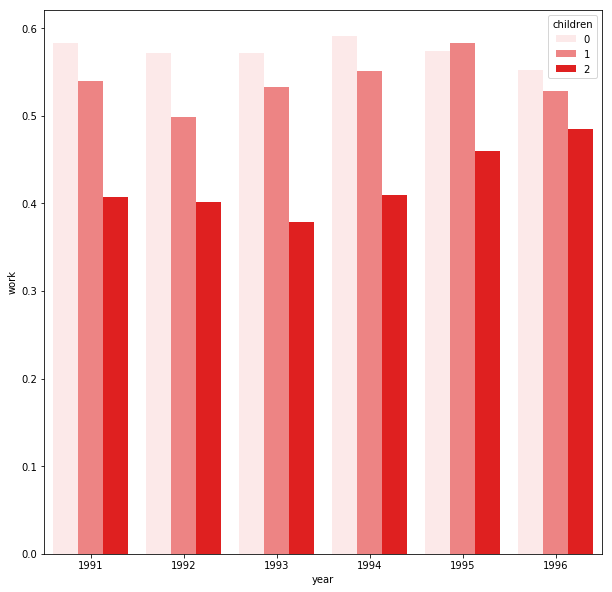

In [243]:
#Grouped object
grouped = pd.DataFrame(eitc1.groupby(['children', 'year'], as_index=False).mean())

#Plotting work against year
plt.figure(figsize=(10,10))
sns.barplot(x="year", y="work", hue='children', data=grouped, color='r')

__Q 1.3: Which families constitute a valid treatment group for the reform of 1993? Which years are
valid before-years and which years are valid after years?__

In [244]:
#Making treatment and control groups. 1: treatment group, 0:control group
eitc['treatment'] = np.where(eitc['children'] > 0, 1, 0)

#Unique years
print(eitc['year'].unique())

#Validating
eitc.head()

[1991 1992 1993 1994 1995 1996]


,year,urate,children,nonwhite,finc,earn,age,ed,work,treatment
0,1991,7.6,0,1,18714.394273,18714.394273,26,10,1,0
1,1991,7.2,1,0,4838.568282,471.365639,22,9,1,1
2,1991,6.4,2,0,8178.193833,0.000000,33,11,0,1
3,1991,9.1,0,1,9369.570485,0.000000,43,11,0,0
4,1991,8.6,3,1,14706.607930,14706.607930,23,7,1,1


From the data we can see that a valid treatment group are families having children. The before years are everything before 1993 since the reform took place in 1993. 
Therefore, before years are specificallt 1991, 1992, 1993 and the rest are after years.

From the table above, I can see that the families having children are considered as 'treatment' group and those not having children are considered as 'control' group.

__Q 1.4: Select the correct subsample (correct years, correct number of children).__

In [245]:
#Making an after year variable
eitc['after_years'] = np.where(eitc['year'] > 1993, 1, 0)

#Validating
eitc.head()

,year,urate,children,nonwhite,finc,earn,age,ed,work,treatment,after_years
0,1991,7.6,0,1,18714.394273,18714.394273,26,10,1,0,0
1,1991,7.2,1,0,4838.568282,471.365639,22,9,1,1,0
2,1991,6.4,2,0,8178.193833,0.000000,33,11,0,1,0
3,1991,9.1,0,1,9369.570485,0.000000,43,11,0,0,0
4,1991,8.6,3,1,14706.607930,14706.607930,23,7,1,1,0


__Q 1.5: Estimate the effect using DiD. Do this using linear regression.__

In [246]:
#Linear Regression
m = smf.ols(formula = 'work ~ treatment * after_years', data=eitc)
print(m.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   work   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     58.45
Date:                Mon, 16 Mar 2020   Prob (F-statistic):           1.54e-37
Time:                        23:39:36   Log-Likelihood:                -9884.9
No. Observations:               13746   AIC:                         1.978e+04
Df Residuals:                   13742   BIC:                         1.981e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.57

__Q 1.6: Comment on your results:__

a) From the above results we can see that the growth of EITC increased working by 0.0469 of the affected families.

b) The p-value of the model is 0.006 which is lesser than 0.05, which shows that the model is statistically significant.

__Q 1.7: Comment on the counterfactual assumption here:__

a) The counter factual assumption here is that the trends for the 'treatment' and 'control' groups would have been same in the abscence of the reform of EITC. EITC would not make a difference.

b) I do not find it convincing as there could be other differences in the 'treatment' and 'control' groups which might have affected differently over time.

__Q 1.8: What do you think about this setup: should we include covariates?__

We should add covariates to the model because we can test the effect of the working better. Including education of women will be a good variation since the research paper has mentioned that EITC also depends on the womens' education level.
The marginal tax rates defer as per the education level of women.

Let's add covariates like education, age, nonwhite and check our result.

__Q 1.9: Include all relevant covariates you have in the data and re-estimate your model. What do you find?__

In [247]:
#Multiple Regression
m1 = smf.ols(formula = 'work ~ treatment * after_years + ed+ age + nonwhite + urate + finc + earn', data=eitc)
print(m1.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   work   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     369.3
Date:                Mon, 16 Mar 2020   Prob (F-statistic):               0.00
Time:                        23:39:40   Log-Likelihood:                -8482.8
No. Observations:               13746   AIC:                         1.699e+04
Df Residuals:                   13736   BIC:                         1.706e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.45

From the above results we can see that the effect of treatment and after years has decreased after adding the covariates. It's now increasing the working by 0.0401 as compared to 0.0469 in the linear regression.

The effect of working has:
Decreased by 0.0535 for treatment

Decreased by 0.0253 for after_years

Increased by 0.0401 for treatment and after years

Increased by 0.0131 for ed

Increased by 0.0027 for age

Decreased by 0.0533 for nonwhite

Decreased by 0.0144 for urate

Very small decrease for finc

Quite large increase for earn

The p-value is still less 0.05, therefore this model is significant as well.


__Q 1.10: Based on the two estimates, give your final word about the efficacy of EITC reform. Feel free to comment the methodology too.__

After evaluating both the estimates, I would like to conclude that the EITC reform in 1993 led to increase in working by the affected families. Therefore, the EITC had a positive effect.


## Q2: Text Classification

__Q 2.1: Load the data__

In [124]:
#Loading data
amazon = pd.read_csv("amazon-reviews.csv.bz2", sep="\t")

In [125]:
#Validating the data
amazon.shape

(205331, 4)

In [126]:
#Checking the head
amazon.head()

,date,summary,review,rating
0,2013-07-16,Awesine,Perfect for new parents. We were able to keep ...,5
1,2013-06-29,Should be required for all new parents!,This book is such a life saver. It has been s...,5
2,2014-03-19,Grandmother watching baby,Helps me know exactly how my babies day has go...,5
3,2013-08-17,repeat buyer,I bought this a few times for my older son and...,5
4,2014-04-01,Great,I wanted an alternative to printing out daily ...,4


In [127]:
#Unique values of rating
amazon['rating'].unique()

array([5, 4, 3, 1, 2], dtype=int64)

In [128]:
#Value counts of review
amazon['review'].isna().value_counts()

False    205251
True         80
Name: review, dtype: int64

__Q 2.2: Remove all the missing and empty observations of review and rating.__

In [129]:
#Removing duplicates from the original data
amazon.drop_duplicates(subset = None, keep = 'first', inplace = True)
amazon.drop(data[data['review'].isna()].index, inplace=True)
amazon.drop(list(data['review'].filter(regex = '\\s+')), axis = 1, inplace = True)
amazon.drop(data[data['review'].str.len() == 0].index, axis = 1, inplace = True)

In [130]:
#Validating the data
amazon.shape

(195831, 4)

In [131]:
#Taking random sample
random.seed(100)
reviews = amazon.sample(n = 1000) 
reviews.shape

(1000, 4)

Now our sample data does not have missings as well.

__Q 2.3: Create your outcome variable: is rating less than 5-stars?__

In [132]:
#Creating an outcome varible: 1 if rating is 5 else 0
Y = np.where(reviews['rating'] ==5 , 1, 0)
print(Y.shape)

(1000,)


__Q 2.4: Take a look at some of the reviews__

In [133]:
#Looking at reviews with rating = 5
reviews[reviews['rating']==5].head()

,date,summary,review,rating
128806,2013-04-09,Makes potty training a little easier.,It must be super comfy because my daughter wil...,5
72192,2013-01-31,Caddy,"Great product, really makes diaper changes for...",5
106717,2012-08-02,Perfect,I get so many compliments on this item. It's a...,5
802,2013-11-20,Great little potty seat,I bought this seat because I (bad mommy) forgo...,5
38260,2011-06-29,Great for on the changing table,For awhile this was hard to find. Amazon had ...,5


In [134]:
#Looking at reviews with rating is not 5
reviews[reviews['rating']!=5].head()

,date,summary,review,rating
92028,2012-01-02,Great product design - but there is off-gassing,I really like that this cuts out all wind / ra...,3
186041,2016-06-21,A lemony powdery fragrance.,Everyone's nose smells scents differently on t...,4
119200,2013-09-04,It just breaks....,I have owned two sets of this product and both...,1
456,2014-04-27,ok cover,"This cover was alright, the hole does seem a b...",4
59128,2011-10-08,Functional & Cute,We bought this activity center for my daughter...,4


According to me, it is easy to judge the reviews with rating 5 because these reviews contain positive words like great, loves, easy, sturdy etc. 

However, as we can see from the above data, I printed out a few rows that do not have the rating 5. Even in some of these reviews, we can see words like gread, worked well etc.

Hence, by just looking at these, if it not so easy to tell which reviews are 5 star and which are not. We need to further investigate these reviews using our models.

__Q 2.5 Convert your reviews into bag-of-words (BOW)__

In [135]:
#Vectorizing reviews, using binary
vectorizer = CountVectorizer(binary=True, stop_words='english')
bow_transformer = vectorizer.fit(reviews['review'])
X = bow_transformer.transform(reviews['review'])
#Sparse matrix
print('Shape of sparse matrix', X.shape)
#Vocabulary 
print(len(bow_transformer.vocabulary_))

Shape of sparse matrix (1000, 6965)
6965


__Q 2.6 Create a model to predict the outcome__

__Here I am going to work with Logistic Regression, Naive Bayes with various alphas, Decision tree, Random forest, Random Forest with Randomized CV, SVM model and predict which one of these fits the best on our data__

_Making Training and testing set:_

In [173]:
random.seed(200)
#Making train and test
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.20)

_Logistic regression model:_

In [174]:
#Decision tree classifier
logmodel = LogisticRegression()
#Fitting the model
logmodel.fit(X_train,y_train)
#Predictions
predictions = logmodel.predict(X_test)
#Classification report
print(classification_report(y_test,predictions))
#Confusion matrix
print(confusion_matrix(y_test,predictions))
#Accuracy score
print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           0       0.64      0.57      0.60        77
           1       0.75      0.80      0.77       123

   micro avg       0.71      0.71      0.71       200
   macro avg       0.69      0.68      0.69       200
weighted avg       0.71      0.71      0.71       200

[[44 33]
 [25 98]]
0.71


_Naive bayes with various alphas:_

In [175]:
#NB with alpha 0.05
nb = MultinomialNB(alpha=0.05) 
#Fitting the model
nb.fit(X_train,y_train)
#Predictions
pred = nb.predict(X_test)
#Accuracy
print("Accuracy score:", accuracy_score(pred,y_test))

Accuracy score: 0.665


In [176]:
#NB with alpha 1
nb = MultinomialNB(alpha=1) 
#Fitting the model
nb.fit(X_train,y_train)
#Predictions
pred = nb.predict(X_test)
#Accuracy
print("Accuracy score:", accuracy_score(pred,y_test))

Accuracy score: 0.73


In [177]:
#NB with alpha 1.2
nb = MultinomialNB(alpha=1.2) 
#Fitting the model
nb.fit(X_train,y_train)
#Predictions
pred = nb.predict(X_test)
#Accuracy
print("Accuracy score:", accuracy_score(pred,y_test))

Accuracy score: 0.735


In [178]:
#NB with alpha 1.5
nb = MultinomialNB(alpha=1.5) 
#Fitting the model
nb.fit(X_train,y_train)
#Predictions
pred = nb.predict(X_test)
#Accuracy
print("Accuracy score:", accuracy_score(pred,y_test))

Accuracy score: 0.735


From the above models we can see that the model with the best accuracy is the one with alpha = 1.5

_Decision tree classifier:_

In [179]:
#Decision tree classifier
dtree = DecisionTreeClassifier()
#Fitting the model
dtree.fit(X_train,y_train)
#Predictions
predictions = dtree.predict(X_test)
#Classification report
print(classification_report(y_test,predictions))
#Confusion matrix
print(confusion_matrix(y_test,predictions))
#Accuracy score
print("Accuracy for decision tree classifier: ", accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           0       0.48      0.49      0.49        77
           1       0.68      0.67      0.67       123

   micro avg       0.60      0.60      0.60       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.60      0.60      0.60       200

[[38 39]
 [41 82]]
Accuracy for decision tree classifier:  0.6


_Random forest classifier:_

In [180]:
#RFC model without hyper parameters and estimators 600
rfc = RandomForestClassifier(n_estimators=1000)
#Fitting the model
rfc.fit(X_train,y_train)
#Prediction
predictions = rfc.predict(X_test)
#Classification report
print(classification_report(y_test,predictions))
#Confusion matrix
print(confusion_matrix(y_test,predictions))
#Accuracy score
print("Accuracy score for Random forest Classifier", accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           0       0.67      0.48      0.56        77
           1       0.72      0.85      0.78       123

   micro avg       0.71      0.71      0.71       200
   macro avg       0.70      0.67      0.67       200
weighted avg       0.70      0.71      0.70       200

[[ 37  40]
 [ 18 105]]
Accuracy score for Random forest Classifier 0.71


_Random forest classifier with Randomized Search CV:_

In [181]:
#First creating a random grid with all the necessary parameters
#Number of trees
n = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

#Bootstrap
bs = [True, False]

#Min. number of samples to split a node
minimum_split = [2, 5, 10]

#Min. number of samples required at each leaf node
minimum_sample = [1, 2, 4]

#Max features at each split
max_features = ['sqrt','auto']

#Max level of the tree
depth = [int(x) for x in np.linspace(10, 100, num = 10)]
depth.append(None)

#Random grid
grid = {'n_estimators': n,
               'max_features': max_features,
               'max_depth': depth,
               'min_samples_split': minimum_split,
               'min_samples_leaf': minimum_sample,
               'bootstrap': bs}

#RandomizedSearch object
rfc = RandomizedSearchCV(estimator = RandomForestClassifier(), 
                         param_distributions = grid, 
                         #Number of iterations 80 with 3 folds
                         n_iter = 80, cv = 3, 
                         verbose=2, 
                         random_state=42, 
                         n_jobs = -1)

#Fitting the training model
rfc.fit(X_train, y_train)

#Checking the best parameters of the model
rfc.best_params_

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.1min finished


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

In [182]:
#Predicting on the test data
pred = rfc.predict(X_test) 
#Accuracy
print("Accuracy for Random Forest Classifier with hyper-parameter tuning:", accuracy_score(pred, y_test))

Accuracy for Random Forest Classifier with hyper-parameter tuning: 0.725


_SVM:_


In [183]:
#SVM without hyper parameters
svc_model = SVC()
#Fitting values
svc_model.fit(X_train,y_train)  
# Predict values on test data
predictions = svc_model.predict(X_test)
#Confusion matrix
print(confusion_matrix(y_test,predictions))
#Classification report
print(classification_report(y_test,predictions))
#Accuracy
print("Accuracy for SVM:", accuracy_score(predictions,y_test))

C:\Users\SP\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[  0  77]
 [  0 123]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.61      1.00      0.76       123

   micro avg       0.61      0.61      0.61       200
   macro avg       0.31      0.50      0.38       200
weighted avg       0.38      0.61      0.47       200

Accuracy for SVM: 0.615


C:\Users\SP\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


__Q 2.7 Which model(s) is the best and how well does it perform?__

The accuracy of the different models are as follows:

Logistic regression: 71%

Naive Bayes with alpha=0.05: 66.5%

Naive Bayes with alpha=1: 73%

Naive Bayes with alpha=1.2: 73.5%

Naive Bayes with alpha=1.5: 73.5%

Decision tree classifier:60%

Random forest classifier:71%

Random forest with Random Search CV: 72.5%

SVM: 62.5%

From all the above coefficients we can see that Naive Bayes with alpha 1.5 and Random Forest with Random Search CV have the higest accuracy values.


__Q 2.8 Do your results broadly correspond to what you guessed based on reading the reviews?__

The best accuracy for this model is about 73.5% which means that it can predict only 73.5% of the times whether a review is rating =5.
My intial assumption holds true as it is very difficult to understand which if reviews have rating=5. The reviews have words like 'great' in both rating = 5 and rating=4, therefore, it's very difficult to differentiate between them.

__The final exam took 12+ hrs.__

Statement of Compliance

Please copy and sign the following statement. You may do it on paper (and include the image file or drop
the sheet in Ott's mailbox in MGH 370), or add the following text with your name and date in your final
document.
I affirm that I have had no conversation regarding this exam with any persons other than the instruc-
tor or the teaching assistant. Further, I certify that the attached work represents my own thinking. Any
information, concepts, or words that originate from other sources are cited in accordance with University
of Washington guidelines as published in the Academic Code (available on the course website). I am
aware of the serious consequences that result from improper discussions with others or from the improper
citation of work that is not my own.

SHREE PRIYA

3/16/2020
